<a href="https://www.kaggle.com/code/hwanchul/lending-club-prep-modeling?scriptVersionId=263441272" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 분석 개요 
___
- 대출자의 부도 예측: 대출 상환에 실패할 (Default) 대출자를 사전에 예측하는 분류(Classification) 문제.

- 타겟 변수 정의: `loan_status`를 활용하여 label 변수 생성
    
    - Default (= True)
        - Charged Off: 대출 상환이 불가능하다고 판단되어 부도 처리된 상태입니다. 이는 회수 가능성이 낮아 손실로 기록된 경우입니다.
        
        - Default: 대출 상환 의무를 이행하지 못해 부도 상태에 빠진 경우입니다. Charged Off와 유사하지만, Lending Club의 내부 정책에 따라 부도 처리 전 단계로 분류됩니다. 
        
        - Late (31-120 days): 대출 상환일로부터 31일에서 120일 사이로 연체된 상태입니다.
        
        - Late (16-30 days): 상환일로부터 16일에서 30일 사이로 연체된 상태입니다.
    
    - Non-Default (= False)
        - Fully Paid: 대출자가 모든 원금과 이자를 전액 상환하여 대출 계약이 완료된 상태입니다. 이는 대출 상환에 성공한 사례로 분류됩니다.
        
        - Current: 대출자가 현재 상환 기한을 잘 지키고 있는 상태입니다. 이 대출들은 아직 계약이 끝나지 않았으며, 현재로서는 부도 위험이 없는 것으로 간주됩니다.
     
    ※ In Grace Period는 아직 부도 여부가 확정되지 않은 상태이므로, 본 분석에서는 제외합니다.

# 데이터 불러오기

In [ ]:
!pip install -U scikit-learn imbalanced-learn

In [ ]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# df1 = pd.read_csv('E:/project/lending-club/accepted_2007_to_2018Q4.csv', low_memory=False)
# df1.shape

# (2260701, 151)

In [ ]:
# 'loan_status' 분포 시각화
from matplotlib.ticker import FuncFormatter
# plt.figure(figsize=(10, 3))

# ax = sns.countplot(data=df1, y='loan_status', order=df['loan_status'].value_counts().index)
# ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x):,}'))    

# plt.title('Loan Status Distribution', fontsize=14, fontweight='bold', pad=10)
# plt.xlabel('Count'); plt.ylabel('')
# plt.show()

이미지  
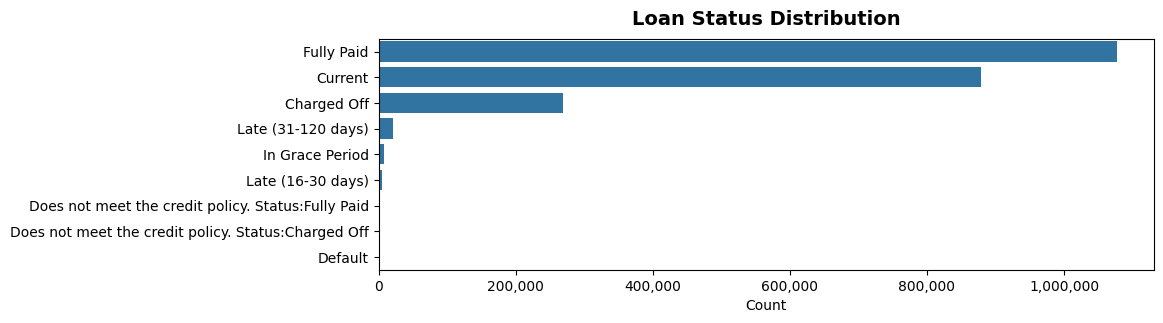

In [ ]:
# 타겟 변수(is_default) 정의
def create_label(df):
    '''
    타겟 변수 is_default 생성 함수
    '''

    def grouping(x):
        if x in ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default']:
            return True
            
        elif x in ['Fully Paid', 'Current']:
            return False
            
        return None 
        
    df_copy = df.copy()
    df_copy['is_default'] = df_copy['loan_status'].apply(grouping).astype(bool)
    df_copy = df_copy.dropna(subset=['is_default'])
    return df_copy

# df1 = create_label(df1)
# df1[['is_default', 'loan_status']].value_counts().sort_index(ascending=False)

# is_default  loan_status                                        
# True        Late (31-120 days)                                       21467
#             Late (16-30 days)                                         4349
#             Default                                                     40
#             Charged Off                                             268559
# False       In Grace Period                                           8436
#             Fully Paid                                             1076751
#             Does not meet the credit policy. Status:Fully Paid        1988
#             Does not meet the credit policy. Status:Charged Off        761
#             Current                                                 878317
# Name: count, dtype: int64

In [ ]:
# 클래스 비율
# df1['is_default'].value_counts(normalize=True)

# is_default
# False    0.869768
# True     0.130232
# Name: proportion, dtype: float64

## 데이터 필터링
___
- 데이터 볼륨이 너무 크기 때문에 주어진 일정 안에 분석이 어려울 것으로 판단하였습니다.
- 클래스 비율을 확인 후 클래스 불균형이 심한 데이터임을 확인하였고, 클래스 불균형도가 비교적 덜 심한 `2015`년 데이터만 활용하여 분석을 진행하였습니다.

In [ ]:
# 연도별 클래스 분포
def plot_class_distribution_by_issue_year(df):
    '''
    연도별 클래스 분포 시각화 함수
    '''

    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
    df['issue_year'] = df['issue_d'].dt.year
    
    yearly_proportions = df.groupby('issue_year')['is_default'].value_counts().unstack().sort_index()
    
    plt.figure(figsize=(10, 4))
    yearly_proportions.plot(kind='bar', stacked=True, ax=plt.gca(), width=0.7)
    
    plt.title('Class Distribution by Issue Year', fontweight='bold', pad=10)
    plt.xlabel('Issue Year', fontsize=12, labelpad=10)
    plt.ylabel('Counts', fontsize=12, labelpad=10)
    plt.xticks(rotation=0)
    plt.legend(title='Default Status', labels=['Non-Default', 'Default'], loc='upper left')
    plt.show()

# plot_class_distribution_by_issue_year(df1)

이미지  
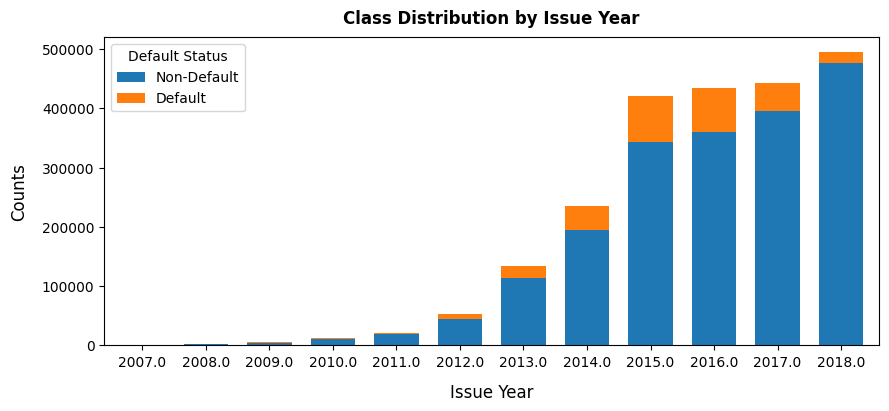

In [ ]:
# 연도별 클래스 비율
def plot_ratio_of_labels_by_year():
    '''
    연도별 클래스 비율 시각화 함수
    '''
    df1['issue_year'] = pd.to_datetime(df1['issue_d']).dt.year
    df_grouped = df1.groupby(['issue_year', 'is_default']).size().unstack()
    df_ratio = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100
    
    df_ratio.plot(kind='bar', stacked=True, figsize=(10, 4))
    
    plt.title('Class Ratio by Issue Year', fontweight='bold', pad=10)
    plt.xlabel('Issue Year')
    plt.ylabel('Proportion (%)')
    plt.xticks(rotation=0)
    plt.legend(title='Default Status', labels=['Non-Default', 'Default'], loc='lower right')
    plt.show()
    
#plot_ratio_of_labels_by_year()

 이미지  
 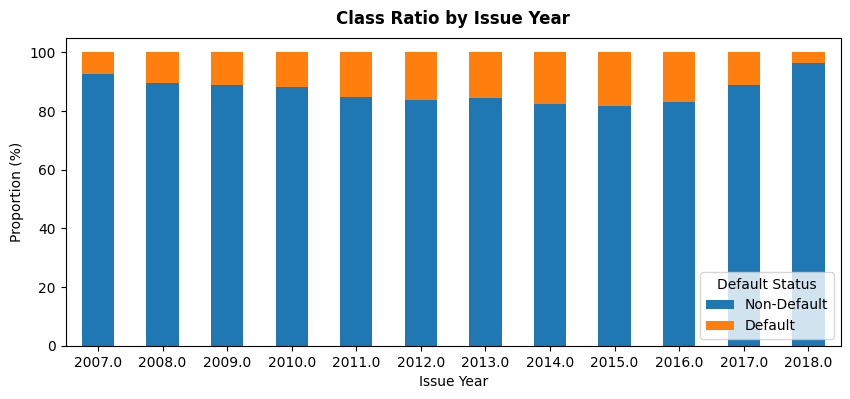
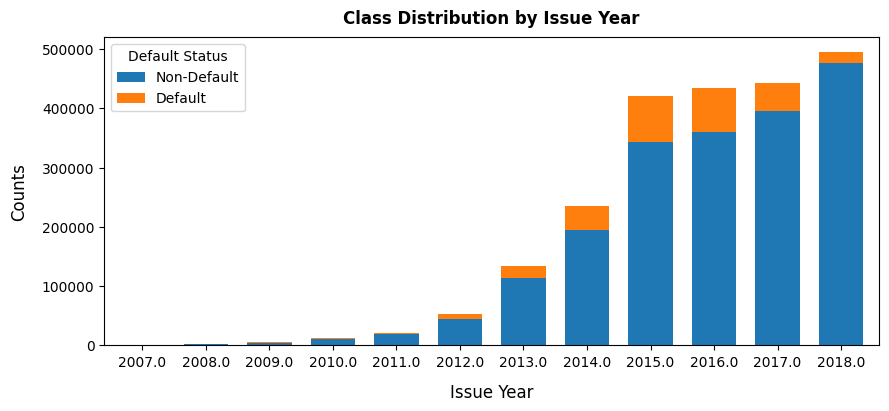
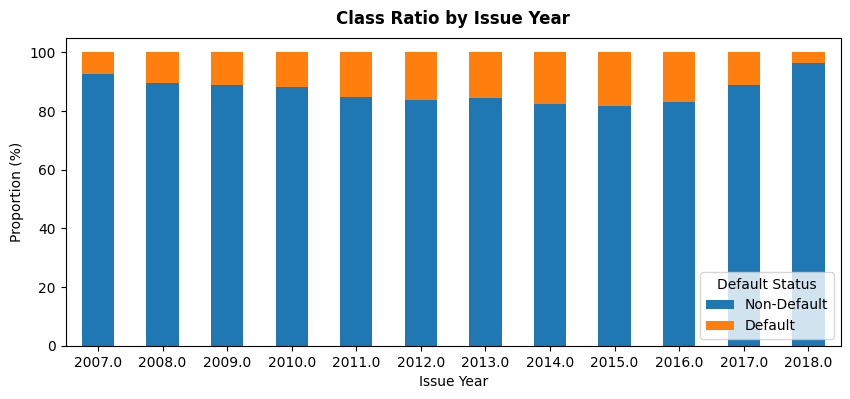

In [ ]:
# issue_year를 기준으로 2015년도 데이터만 분석에 활용
#df1 = df1[df1['issue_year'] == 2015]
#df1.to_csv('accepted_2015.csv', index=False)

# 대출 승인/반려 시 주로 활용하는 대출자의 정보

현업에서 대출 승인/반려 시 주로 활용하는 대출자의 정보는 크게 네 가지 범주로 나눌 수 있습니다. 이 정보들은 단순히 개인의 신용도를 넘어, 상환 능력과 행동 패턴을 종합적으로 평가하는 데 사용됩니다.
___

### **1. 신용 정보**

가장 핵심적인 정보로, 금융기관이 대출자의 과거 금융 생활을 평가하는 데 필수적입니다.

- **신용 점수 및 등급**: 대출자의 신용 위험을 숫자로 압축한 지표입니다. FICO 점수(미국)나 KCB/NICE 등급(한국)이 여기에 속합니다. 이 점수를 기반으로 대출 승인 여부와 금리가 결정됩니다.
  
    \- 신용점수 관련
> - `fico_range_high` / `fico_range_low` : 대출자의 FICO 신용 점수 범위
> - `last_fico_range_high` / `last_fico_range_low` : 마지막 신용 조회 시 FICO 점수 범위
> - `sec_app_fico_range_high` / `sec_app_fico_range_low` : 2차 신청자의 FICO 신용 점수

    - 등급 관련
> - `grade` : Lending Club의 내부 신용 등급 (A~G)
> - `sub_grade` : Lending Club의 내부 신용 등급. grade보다 더 세분화된 신용 등급 (A1~G5)
  

- **신용 계좌 수 및 신용이력 기간**: 대출자의 신용 거래의 활동성을 판단하고 얼마나 오래되었는지를 나타냅니다. 신용 이력이 길수록 금융 생활이 안정적이라고 판단할 수 있습니다.

| 계좌 유형 | 계좌 수 | 계좌 활동 |
| :--- | :--- | :--- |
| **신용 계좌** | `total_acc`<br>`open_acc`<br>`num_sats`<br>`acc_now_delinq` | `earliest_cr_line`<br>`acc_open_past_24mths`<br>`open_acc_6m`<br>`num_tl_op_past_12m`<br>`mo_sin_rcnt_tl` |
| **회전식/리볼빙 계좌** | `num_rev_accts`<br>`num_op_rev_tl`<br>`num_rev_tl_bal_gt_0`<br>`num_actv_rev_tl`<br>`mths_since_recent_revol_delinq` | `open_rv_12m`<br>`open_rv_24m`<br>`mo_sin_old_rev_tl_op`<br>`mo_sin_rcnt_rev_tl_op` |
| **할부 계좌** | `num_il_tl`<br>`open_act_il`<br>`total_bal_il`<br>`il_util`<br>`total_il_high_credit_limit` | `open_il_12m`<br>`open_il_24m`<br>`mths_since_rcnt_il`<br>`mo_sin_old_il_acct` |
| **신용카드 계좌** | `num_bc_tl`<br>`num_bc_sats`<br>`num_actv_bc_tl`<br>`mths_since_recent_bc_dlq` | `mths_since_recent_bc` |
| **기타 계좌** | `total_cu_tl`<br>`mort_acc` | - |
| **공동 대출 신청자** | `sec_app_open_acc`<br>`sec_app_mort_acc`<br>`sec_app_open_act_il`<br>`sec_app_num_rev_accts`<br>`sec_app_revol_util` | `sec_app_earliest_cr_line` |  

-  **과거 상환 이력**

대출자의 과거 상환 이력은 단순히 연체 여부를 넘어, 현재 상환 상태, 부도 경험, 그리고 공적인 기록까지 종합적으로 평가하는 데 활용됩니다.
  
    - 현재 대출 상태 및 금액 관련  
> - `out_prncp`, `out_prncp_inv` : 잔여 원금
> - `total_pymnt`, `total_pymnt_inv` : 상환한 총 금액
> - `total_rec_prncp`, `total_rec_int`, `total_rec_late_fee` : 상환한 총 원금, 이자, 연체료
> - `recoveries`, `collection_recovery_fee` : 부도 후 회수 금액 및 관련 비용

    - 최근 상환 정보  
> - `last_pymnt_d`, `last_pymnt_amnt` : 마지막 상환일 및 금액
> - `next_pymnt_d` : 다음 상환 예정일

    - 연체 및 채무불이행 기록
> - `delinq_2yrs` : 지난 2년간의 연체 건수
> - `delinq_amnt` : 연체 금액
> - `num_tl_30dpd` : 지난 30일 이상 연체된 계좌 수
> - `num_tl_90g_dpd_24m` : 지난 2년간 90일 이상 연체된 계좌 수
> - `num_accts_ever_120_pd` : 120일 이상 연체된 계좌 총 개수
> - `num_tl_120dpd_2m` : 지난 2년간 120일 이상 연체된 계좌 수
> - `pct_tl_nvr_dlq` : 한 번도 연체되지 않은 계좌의 비율
> - `mths_since_last_major_derog` : 마지막 주요 채무 불이행 후 경과 개월 수
> - `chargeoff_within_12_mths` : 지난 12개월간 부도 처리된 계좌 수
> - `collections_12_mths_ex_med` : 지난 12개월간 의료비 관련을 제외한 채권 추심 건수
> - `tot_coll_amt` : 채권 추심에 넘어간 금액의 총합


    - 공개 기록
> - `pub_rec` : 공개 기록 건수
> - `pub_rec_bankruptcies` : 공개 파산 기록 건수
> - `tax_liens` : 세금 체납 기록 건수
> - `mths_since_last_record` : 마지막 공개 기록 후 경과 개월 수


    - 공동 대출 신청자 기록
> - `sec_app_chargeoff_within_12_mths`
> - `sec_app_collections_12_mths_ex_med`
> - `sec_app_mths_since_last_major_derog`


- **신용카드 사용률(Credit Utilization Ratio)**: 사용 가능한 신용 한도 대비 사용액의 비율입니다. 이 비율이 높을수록 재정적 압박이 심하다고 판단할 수 있습니다.
> - `revol_util`, `sec_app_revol_util` : 리볼빙 신용 한도 사용률
> - `revol_bal`, `revol_bal_joint`: 리볼빙 신용 한도의 잔고
> - `il_util` : 할부 계좌의 총 신용 한도 사용률
> - `all_util` : 모든 신용 계좌의 총 신용 한도 사용률
> - `bc_util` : 신용카드 계좌 한도 사용률
> - `total_rev_hi_lim` : 모든 회전식 신용 계좌의 총 신용 한도
> - `total_il_high_credit_limit` : 모든 할부 계좌의 총 높은 신용 한도
> - `total_bc_limit` : 신용카드 계좌의 총 한도
> - `percent_bc_gt_75` : 신용 한도 75% 이상 사용 중인 신용카드 비율

- **신용 조회 건수**: 단기간에 여러 금융기관에 대출을 신청하는 것은 긴급 자금이 필요하거나 재정적으로 불안정하다는 신호로 해석될 수 있어 대출 심사에 불리하게 작용합니다.
> - `inq_last_6mths`, `inq_last_12m` : 신용 조회 건수
> - `inq_fi` : 금융 기관 조회 건수
> - `mths_since_recent_inq` : 최근 신용 조회 후 경과 개월 수
> - `last_credit_pull_d` : 마지막 신용 조회일
> - `sec_app_inq_last_6mths` : 2차 신청자의 지난 6개월간 신용 조회 건수

### **2. 재정 상태**

대출금을 상환할 수 있는 능력을 직접적으로 평가하는 정보입니다.

- **소득 및 고용 정보**: 연봉, 월급, 고용 형태(정규직, 계약직, 자영업) 등을 확인하여 안정적인 소득 흐름을 검증합니다.
> - `annual_inc`, `annual_inc_joint` : 연간 수입
> - `emp_title` : 직업
> - `emp_length` : 현 직장 근무 기간
> - `verification_status`, `verification_status_joint` : 수입 검증 상태

- **부채 대 소득 비율(Debt-to-Income Ratio, DTI)**: 월 소득 대비 월 상환액의 비율입니다. 이 비율이 높을수록 상환 부담이 크다고 판단합니다.
> - `dti` : 부채-소득 비율

- **자산 및 부채**: 보유 자산(부동산, 예금)과 부채(기존 대출금)를 종합적으로 파악하여 순자산 가치를 평가합니다.
> - `tot_cur_bal` : 모든 계좌의 총 현재 잔액
> - `tot_hi_cred_lim` : 총 신용 한도
> - `total_bal_ex_mort` : 모기지 제외 모든 계좌의 총 잔액
> - `avg_cur_bal` : 모든 계좌의 평균 현재 잔액

___

### **3. 대출 신청 정보**

신용 평가 외에, 대출 자체의 특징이 리스크를 결정하는 데 중요하게 작용합니다.

- **대출 금액 및 기간**: 대출 금액이 클수록, 상환 기간이 길수록 금융기관의 리스크는 커집니다.
> - `loan_amnt` : 대출 신청 금액
> - `funded_amnt` : 투자자들이 실제 투자한 금액
> - `funded_amnt_inv` : 대출 발행 이후 투자자들에게 판매된 금액
> - `term` : 대출 상환 기간
> - `int_rate` : 대출 이자율
> - `installment` : 매월 지불해야 하는 할부 금액
> - `issue_d` : 대출이 승인되어 발행된 날짜

- **대출 목적**: 주택 구입, 학자금, 사업 자금 등 대출 목적에 따라 심사 기준이 달라질 수 있습니다.
> - `purpose` : 대출의 목적
> - `title` : 대출자가 지정한 대출 제목

- **기타 대출 관련**:
> - `id`, `member_id`, `url`, `desc`, `policy_code`, `application_type`, `disbursement_method`, `initial_list_status`, `loan_status`, `pymnt_plan`

___

### **4. 개인 및 행동 정보**

위의 정량적인 정보 외에, 대출자의 특성을 파악하는 데 활용됩니다.

- **주거 형태**: 자가 소유 여부는 재정적 안정성을 나타내는 지표가 될 수 있습니다.
> - `home_ownership` : 대출자의 주택 소유 형태

- **지역 정보**:
> - `zip_code` : 대출자가 등록한 우편번호의 앞 3자리
> - `addr_state` : 대출자의 주소지 주

- **공개 기록 및 채무 조정**:
> - `pub_rec` : 대출자의 공개 기록(예: 파산, 세금 체납) 건수
> - `pub_rec_bankruptcies` : 공개 파산 기록 건수
> - `tax_liens` : 세금 체납 기록 건수
> - `hardship_flag`, `hardship_type`, `hardship_reason`, `hardship_status`, `deferral_term`, `hardship_amount`, `hardship_start_date`, `hardship_end_date`, `payment_plan_start_date`, `hardship_length`, `hardship_dpd`, `hardship_loan_status`, `orig_projected_additional_accrued_interest`, `hardship_payoff_balance_amount`, `hardship_last_payment_amount`
> - `debt_settlement_flag`, `debt_settlement_flag_date`, `settlement_status`, `settlement_date`, `settlement_amount`, `settlement_percentage`, `settlement_term`

# 데이터 탐색 및 결측치 전처리

## 결측치 전처리

In [ ]:
# 2015년 데이터 불러오기
path = '/kaggle/input/iendingclub-prep-2015/'
df = pd.read_csv(path + 'accepted_2015.csv')
df

- 분석 데이터를 확인하니, 다수의 컬럼에서 결측이 식별되었습니다. 
- 결측 전처리부터 수행하였습니다. 
    

In [ ]:
def plot_missing_counts_by_columns(df):
    '''
    컬럼별 결측치 숫자 및 비율 시각화 및 반환 함수
    '''

    # 컬럼별 결측치 숫자 및 비율 정보 추출
    missing_count = df.isnull().sum() 
    missing_ratio = (missing_count / len(df)) * 100
    missing_info = pd.DataFrame({'Missing_Count': missing_count, 'Missing_Ratio': missing_ratio})
    missing_info = missing_info[missing_info['Missing_Count'] != 0].sort_values(by='Missing_Count')
    
    # 시각화 
    height = 5 + len(missing_info) // 10
    
    plt.figure(figsize=(20, height))
    ax = missing_info['Missing_Count'].plot(kind='barh')
    
    for p in ax.patches:
        ax.annotate(str(int(p.get_width())), (p.get_width() * 1.01, p.get_y() + p.get_height() / 2),
                    ha='left', va='center')
                    
    plt.title('Missing Counts per Columns', fontweight='bold', pad=15, fontsize=16)
    plt.xlabel('Number of Missing Values')
    plt.ylabel('Columns')
    plt.show()

    return missing_info

missing_df = plot_missing_counts_by_columns(df)

결측 비율 40% 초과 컬럼 정보 요약 
___
- 공동 대출 신청자 관련 컬럼 (4개)
- 2차 신청자 관련 컬럼 (12개)
- 채무 조정 및 부도 관련 컬럼 (20개)
- 신용 조회 및 계좌 관련 컬럼 (14개)
- 기타 대출 정보 (7개)


In [ ]:
# 결측 비율 40% 초과 컬럼 정보
print(missing_df[missing_df['Missing_Ratio'] >= 40])
missing_df[missing_df['Missing_Ratio'] >= 40].shape

공동 대출 신청자 관련 컬럼  
- annual_inc_joint: 공동 신청 시 연간 소득
- dti_joint: 공동 신청 시 부채-소득 비율
- verification_status_joint: 공동 신청 시 소득 확인 상태
- revol_bal_joint: 공동 신청 시 회전식 신용 잔고

In [ ]:
joint_related_columns = [col for col in missing_df.index if 'joint' in col]
display(missing_df.loc[joint_related_columns])

missing_df = missing_df.drop(joint_related_columns)
df = df.drop(joint_related_columns, axis=1)

2차 신청자 관련 컬럼

- sec_app_collections_12_mths_ex_med: 2차 신청자의 12개월 내 의료 제외 채권 추심 기록
- sec_app_chargeoff_within_12_mths: 2차 신청자의 12개월 내 부도 처리 기록
- sec_app_num_rev_accts: 2차 신청자의 신용 계좌 수
- sec_app_open_act_il: 2차 신청자의 할부 계좌 수
- sec_app_open_acc: 2차 신청자의 개설된 총 계좌 수
- sec_app_inq_last_6mths: 2차 신청자의 최근 6개월 내 신용 조회 수
- sec_app_mort_acc: 2차 신청자의 모기지 계좌 수
- sec_app_fico_range_high / low: 2차 신청자의 FICO 신용 점수
- sec_app_earliest_cr_line: 2차 신청자의 가장 오래된 신용 거래 기록
- sec_app_revol_util: 2차 신청자의 신용 한도 사용률
- sec_app_mths_since_last_major_derog: 2차 신청자의 마지막 주요 채무 불이행 후 경과 개월 수

In [ ]:
sec_app_related_columns = [col for col in missing_df.index if 'sec_app' in col]

display(missing_df.loc[sec_app_related_columns])
missing_df.loc[sec_app_related_columns].shape

missing_df = missing_df.drop(sec_app_related_columns)
df = df.drop(sec_app_related_columns, axis=1)

채무 조정 및 부도 관련 컬럼 (20개)

- settlement_amount: 채무 조정 금액
- settlement_status: 채무 조정 상태
- settlement_date: 채무 조정일
- debt_settlement_flag_date: 채무 조정 플래그 설정일
- settlement_term: 채무 조정 기간
- settlement_percentage: 채무 조정된 금액의 비율
- hardship_status: 재정적 어려움 상태
- hardship_reason: 재정적 어려움 사유
- deferral_term: 상환 유예 기간
- hardship_amount: 재정적 어려움 지원 금액
- hardship_start_date / end_date: 재정적 어려움 시작/종료일
- hardship_type: 재정적 어려움 유형
- hardship_length: 재정적 어려움 기간
- hardship_last_payment_amount: 재정적 어려움 프로그램 내 마지막 상환액
- hardship_payoff_balance_amount: 재정적 어려움 프로그램 내 완납 잔액
- hardship_loan_status: 재정적 어려움 프로그램 내 대출 상태
- hardship_dpd: 재정적 어려움 프로그램 내 연체일 수
- payment_plan_start_date: 상환 계획 시작일입니다.
- deferral_term: 상환 유예 기간입니다.
- orig_projected_additional_accrued_interest: 재정적 어려움 프로그램으로 인해 발생한 추가 이자

In [ ]:
settlement_related_columns = [col for col in missing_df.index if 'settlement' in col]
hardship_related_columns = [col for col in missing_df.index if 'hardship' in col] \
                         + ['orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'deferral_term']

display(missing_df.loc[settlement_related_columns + hardship_related_columns])
missing_df.loc[settlement_related_columns + hardship_related_columns].shape

missing_df = missing_df.drop(settlement_related_columns + hardship_related_columns)
df = df.drop(settlement_related_columns + hardship_related_columns, axis=1)

신용 조회 및 계좌 관련 컬럼 (14개)

- inq_last_12m: 최근 12개월간 신용 조회 건수.
- inq_fi: 최근 융자(mortgage/revolving 제외) 관련 조회 건수.
- open_rv_12m: 최근 12개월간 신규 회전식 계좌(신용카드 등) 개설 수.
- open_rv_24m: 최근 24개월간 신규 회전식 계좌 개설 수.
- open_il_12m: 최근 12개월간 신규 할부 계좌 개설 수.
- open_il_24m: 최근 24개월간 신규 할부 계좌 개설 수.
- open_acc_6m: 최근 6개월간 신규 신용 계좌 개설 수.
- open_act_il: 현재 개설된 할부 계좌 수.
- total_cu_tl: 신용 조합(credit union) 계좌 총 개수.
- total_bal_il: 할부 계좌(차량, 학자금 대출 등)의 총 잔액.
- mths_since_rcnt_il: 최근 할부 계좌 개설 후 경과 개월 수.
- il_util: 할부 계좌의 총 신용한도 사용률.
- all_util: 모든 신용 계좌의 총 신용한도 사용률.
- max_bal_bc: 신용카드 계좌의 최대 잔액.

In [ ]:
keywords_to_filter = ['inq_', 'open_rv', 'open_il', 'open_ac', 'total_', 'il_util', 'all_util', 'max_bal_bc', 'mths_since_rcnt_il']

credit_inquiry_related_columns = [col for col in missing_df.index if any(keyword in col for keyword in keywords_to_filter)]

display(missing_df.loc[credit_inquiry_related_columns])
missing_df.loc[credit_inquiry_related_columns].shape

missing_df = missing_df.drop(credit_inquiry_related_columns)
df = df.drop(credit_inquiry_related_columns, axis=1)

기타 대출 정보 (7개)  
- next_pymnt_d: 다음 상환일.
- mths_since_last_delinq: 마지막 연체 후 경과 개월 수.
- mths_since_recent_revol_delinq: 최근 리볼빙 계좌 연체 후 경과 개월 수.
- mths_since_last_major_derog: 마지막 주요 채무 불이행 후 경과 개월 수.
- mths_since_recent_bc_dlq: 최근 신용카드 연체 후 경과 개월 수.
- mths_since_last_record: 마지막 공개 기록(파산 등) 후 경과 개월 수.
- desc: 대출 신청자가 작성한 대출 설명


In [ ]:
keywords_to_filter = ['next_pymnt_d', 'mths_since_la', 
                      'mths_since_recent_revol_delinq', 'mths_since_recent_bc_dlq', 'mths_since_last_record', 'desc']
                      
etc_features = [col for col in missing_df.index if any(keyword in col for keyword in keywords_to_filter)]

display(missing_df.loc[etc_features])
missing_df = missing_df.drop(etc_features)

In [ ]:
df['next_pymnt_d'].str.split('-', expand=True)[1].value_counts() # next_pymnt_d

- 결측 비율이 89%인데다가 불균형이 심한 특징이라 활용하기 어려워 보임

In [ ]:
# 연체 기록이 없는 경우
df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(-1) 
df['mths_since_recent_revol_delinq'] = df['mths_since_recent_revol_delinq'].fillna(-1) 
df['mths_since_last_major_derog'] = df['mths_since_last_major_derog'].fillna(-1)
df['mths_since_recent_bc_dlq'] = df['mths_since_recent_bc_dlq'].fillna(-1)
df['mths_since_last_record'] = df['mths_since_last_record'].fillna(-1)

df = df.drop(['next_pymnt_d', 'desc'], axis=1) # 활용 불가능

결측 비율 4% 초과 컬럼

- mths_since_recent_inq: 최근 신용 조회(새로운 신용 신청 이력(예, 대출 신청, 카드 신청 등)이 있을 때 발생) 후 경과 개월 수.
- emp_title: 직업명.
- emp_length: 현 직장 근무 기간.
- num_tl_120dpd_2m: 최근 2년간 120일 이상 연체된 계좌 수.

In [ ]:
keywords_to_filter = ['num_tl_120dpd_2m', 'mths_since_recent_inq', 'emp_title', 'emp_length']

missing_above_4p = [col for col in missing_df.index if any(keyword in col for keyword in keywords_to_filter)]

display(missing_df.loc[missing_above_4p])

missing_df = missing_df.drop(missing_above_4p)
df['mths_since_recent_inq'] = df['mths_since_recent_inq'].fillna(-1) # 새로운 신용 신청 이력이 없는 경우로 판단
df['num_tl_120dpd_2m'] = df['num_tl_120dpd_2m'].fillna(0) # 연체 이력이 없는 케이스로 판단
df['emp_title'] = df['emp_title'].fillna('None') # 직업이 없는 케이스로 판단
df['emp_length'] = df['emp_length'].fillna(0) # 직업이 없는 케이스로 판단

나머지 컬럼

- num_rev_accts: 리볼빙 계좌 수
- dti: 부채-소득 비율
- last_credit_pull_d: 마지막 신용 조회일
- title: 대출자가 기입한 대출 목적 제목
- revol_util: 리볼빙 계좌 신용 한도 사용률
- mths_since_recent_bc: 최근 신용카드 개설 후 경과 개월 수
- bc_open_to_buy: 신용카드 한도 대비 여유 금액
- bc_util: 신용카드 한도 사용률
- percent_bc_gt_75: 한도 75% 이상 사용 중인 신용카드 비율
- mo_sin_old_il_acct: 가장 오래된 할부 계좌 개설 후 경과 개월 수


In [ ]:
display(missing_df)
missing_df.shape

df['dti'] = df['dti'].fillna(df['dti'].median())
df['title'] = df['title'].fillna('None') # 대출 시 title 작성 안한 경우로 판단
df['revol_util'] = df['revol_util'].fillna(0) # 리볼빙 계좌가 없다고 판단

# 비율 
df['bc_open_to_buy'] = df['bc_open_to_buy'].fillna(0)
df['bc_util'] = df['bc_util'].fillna(0) 
df['percent_bc_gt_75'] = df['percent_bc_gt_75'].fillna(0)

# 경과 개월 수
df['mths_since_recent_bc'] = df['mths_since_recent_bc'].fillna(-1)
df['mo_sin_old_il_acct'] = df['mo_sin_old_il_acct'].fillna(-1)

# 결측 비율이 낮기 때문에 drop 처리
df = df.dropna(subset=['num_rev_accts', 'last_credit_pull_d']) 

In [ ]:
# 불필요한 특징 제거
df = df.drop([ 'id', 'member_id', 'url'], axis=1)

In [ ]:
df.isna().sum().sort_values().tail(5)

In [ ]:
df.shape

## 범주형 특징

In [ ]:
categorical_columns = df.select_dtypes('object').columns 

summary_cat_features = {}
for col in categorical_columns:
  nuniq = df[col].nunique()
  vals = df[col].unique()
  summary_cat_features[col] = {'n_unique': nuniq, 'values': vals}

summary_cat_features = pd.DataFrame(summary_cat_features).T.sort_values('n_unique')
display(summary_cat_features)

In [ ]:
def extract_year_month(df):
    cols = ['issue_d', 'last_credit_pull_d', 'earliest_cr_line']
    for col in cols:
        df[col] = pd.to_datetime(df[col])
        df[col + '_year'] = pd.to_datetime(df[col]).dt.year
        df[col + '_month'] = pd.to_datetime(df[col]).dt.month
        df = df.drop(col, axis=1)
    return df
df = extract_year_month(df)

disbursement_method, pymnt_plan

In [ ]:
df = df.drop('disbursement_method', axis=1) # nunique = 1
df['term'] = df['term'].str[:3].astype(int)
df['pymnt_plan'] = df['pymnt_plan'].map({'y':True, 'n':False}) # y/n -> boolean

emp_title
- 특수문자, 대소문자가 혼용되어 있어 자연어 전처리를 수행하였습니다.

In [ ]:
def func_emp_title(df):
    df_copy = df.copy()

    df_copy['emp_title'] = df_copy['emp_title'].astype(str).str.lower()
    df_copy['emp_title'] = df_copy['emp_title'].str.replace(r'\t', '', regex=True)
    df_copy['emp_title'] = df_copy['emp_title'].str.replace(r'[^\w\s]', '', regex=True)
    df_copy['emp_title'] = df_copy['emp_title'].str.replace(r'\s+', ' ', regex=True)
    
    return df_copy

df = func_emp_title(df)
print(df['emp_title'].nunique())

earliest_cr_line --> credit_history_mths (신용거래기간)
- 신용거래기간은 얼마나 오랫동안 신용을 관리해왔는지 알려주는 지표로 신용평가에 중요한 정보로 활용되고 있습니다.
- `earliest_cr_line` 특징은 nunique 가 688개로 인코딩 시 모델의 복잡도를 높여 학습이 비효율적이라고 판단하였습니다. 
- 이에, `issue_d`를 활용하여 신용거래기간 특징을 생성하였습니다.



In [ ]:
def create_credit_history(df):
    df_copy = df.copy()
    
    # 신용거래기간
    df_copy['credit_history_mths'] = (
        (df_copy['issue_d_year'] - df_copy['earliest_cr_line_year']) * 12 +
        (df_copy['issue_d_month'] - df_copy['earliest_cr_line_month']))
    
    #df_copy = df_copy.drop(['issue_d_dt', 'earliest_cr_line_dt', 'earliest_cr_line'], axis=1)
    #df_copy = df_copy.drop(['issue_d_dt', 'earliest_cr_line_dt'], axis=1)
    
    return df_copy

df = create_credit_history(df)
df['credit_history_mths'].head(3)

last_credit_pull_d --> mths_since_last_credit_check (마지막 신용 조회 후 경과기간)

- issue_d와 last_credit_pull_d 정보를 활용하여 마지막 신용조회 후 경과기간 특징을 생성하였습니다.


In [ ]:
def create_mths_since_last_credit_check(df):
    df_copy = df.copy()
    
    df_copy['mths_since_last_credit_check'] = (
        (df_copy['issue_d_year'] - df_copy['last_credit_pull_d_year']) * 12 +
        (df_copy['issue_d_month'] - df_copy['last_credit_pull_d_month']))
    
    df_copy['mths_since_last_credit_check'] = np.where(
        df_copy['mths_since_last_credit_check'] < 0, 0, df_copy['mths_since_last_credit_check'])
    
    #df_copy = df_copy.drop(['last_credit_pull_d', 'issue_d_dt', 'last_credit_pull_d_dt'], axis=1)
    
    return df_copy

df = create_mths_since_last_credit_check(df)
df['mths_since_last_credit_check'].head(3)

※ 여기서 mths_since_recent_inq vs. time_since_last_credit_check의 차이
- mths_since_recent_inq (최근 신용 조회 후 경과 개월 수):
이 변수는 하드 인콰이어리(Hard Inquiry), 즉 대출이나 신용카드와 같이 새로운 신용을 신청한 시점을 기준으로 합니다. 하드 인콰이어리는 신용 점수에 영향을 미칠 수 있습니다. 짧은 기간에 여러 번 발생하면 재정적 어려움의 신호로 해석될 수 있습니다.

- mths_since_last_credit_check (마지막 신용 조회 후 경과 기간):
이 변수는 신용 풀(Credit Pull), 즉 하드 인콰이어리와 소프트 인콰이어리(Soft Inquiry)를 모두 포함합니다. 소프트 인콰이어리는 본인이 자신의 신용을 조회하거나, 광고성 목적의 신용 조회를 할 때 발생하며 신용 점수에 영향을 주지 않습니다.

grade, sub_grade

- sub_grade의 앞철자는 'A'부터 'G'까지, 뒤에 있는 숫자는 '1'부터 '5'의 값을 가집니다.
- 이를 순서대로 수치형으로 변환하였습니다. 예, 'A1'--> 35, 'A2'--> 34, ... , 'G5'--> 1

In [ ]:
def transform_sub_grade(df):
    df_copy = df.copy()
    
    grades_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    grade_map = {grade: len(grades_order) - i for i, grade in enumerate(grades_order)}
    df_copy['grade'] = df_copy['grade'].map(grade_map)
    
    sub_grades_ordered = [f'{g}{i}' for g in grades_order for i in range(1, 6)]
    sub_grade_map = {sub: len(sub_grades_ordered) - i for i, sub in enumerate(sub_grades_ordered)}
    df_copy['sub_grade'] = df_copy['sub_grade'].map(sub_grade_map)
        
    return df_copy

## transform_sub_grade(df)['grade'].value_counts().sort_index() #체크용
df = transform_sub_grade(df)
df['grade'].head(3), df['sub_grade'].head(3)

emp_length

In [ ]:
def func_emp_length_to_numeric(df):
    emp_length_mapping = {
        '10+ years': 10,
        '9 years': 9,
        '8 years': 8,
        '7 years': 7,
        '6 years': 6,
        '5 years': 5,
        '4 years': 4,
        '3 years': 3,
        '2 years': 2,
        '1 year': 1,
        '< 1 year': 0.5,
        0: 0
    }
    df['emp_length'] = df['emp_length'].map(emp_length_mapping).astype(float)
    return df

df = func_emp_length_to_numeric(df)

title
- 빈도수가 1인 값들은 Other로 변환하였습니다

In [ ]:
def func_title(df):
  tmp = df['title'].value_counts()
  others = tmp[tmp<=1].index

  df['title'] = df['title'].replace(others, 'Other')
  return df

df = func_title(df)

범주형 특징 전처리 결과 확인

In [ ]:
categorical_columns = df.select_dtypes('object').columns 

summary_cat_features = {}
for col in categorical_columns:
  nuniq = df[col].nunique()
  vals = df[col].unique()
  summary_cat_features[col] = {'n_unique': nuniq, 'values': vals}

summary_cat_features = pd.DataFrame(summary_cat_features).T.sort_values('n_unique')
display(summary_cat_features)

위 특징들은 train_test_split 후 인코딩 진행하였습니다

In [ ]:
df[categorical_columns].info()

## 수치형 특징

In [ ]:
int_features = df.select_dtypes('int').columns
float_features = df.select_dtypes('float').columns

len(int_features), len(float_features)

int type

In [ ]:
df[int_features].describe()

정수 타입 특징 중 `time_since_last_credit_check`의 기술통계량을 보고 한쪽으로 치우친 분포를 가지고 있다고 판단하여 시각화를 진행하였습니다.

In [ ]:
plt.figure(figsize = (12, 5))

plt.subplot(121)
sns.histplot(df['mths_since_last_credit_check'])
plt.title('Original Distribution of time_since_last_credit_check')

plt.subplot(122)
sns.histplot(np.log1p(df['mths_since_last_credit_check']))
plt.title('Log-transformed Distribution of time_since_last_credit_check')

In [ ]:
plt.figure(figsize=(8, 5))

sns.countplot(data=df, x='mths_since_last_credit_check', hue='is_default', palette='viridis')
plt.title('Distribution of time_since_last_credit_check by is_default')
plt.xlabel('Time Since Last Credit Check')
plt.ylabel('Count')
plt.show()

`time_since_last_credit_check`는 한쪽으로 크게 기울어진 분포를 가진 특징이지만 타겟 특징과의 분포 확인 결과, 분류에 유의미할 것으로 판단하였습니다.

float type  
- 전처리된 데이터 기준으로 총 66개로 구성되며, 모두 분포를 시각화하며 확인할 수 없기 때문에 기술통계량을 기준으로 필터링 후 시각화를 통해 분포를 확인하였습니다.
- 분석 제외 대상인 데이터 누수 특징은 제거 후 진행하였습니다.
- 분포-불균형 특징 식별
    - 기술 통계량 결과를 바탕으로, 평균 및 표준편차와 비교했을 때 최대/최소 값의 차이가 큰 특징들을 식별하였습니다.
    - 기준 : `max > mean + 3*std` 또는 `min < mean - 3*std`

데이터 누수 의심 특징들 
___
대출(상환) 상태 관련  
-  `loan_status`: 대출 상태 (삭제 처리- target variance 생성에 활용됨)
- `total_rec_prncp`, `total_pymnt`, `total_pymnt_inv` : 총 대출금 상환 관련
- `recoveries`, `collection_recovery_fee`: 부도 상태(Charged off) 이후 발생하는 정보
- `debt_settlement_flag` , `hardship_flag`: 특별상환 계획 진행 관련
- `last_pymnt_amnt`, `last_pymnt_d`: 최근 상환 관련 금액, 일자  

잔여 원금 및 신용점수 관련  
- `last_fico_range_high`, `last_fico_range_low`: 최근 FICO 신용점수 high/low
- `out_prncp_inv`, `out_prncp`: 남은 원금 

In [ ]:
# 데이터 누수 특징
features_data_leakage_related = [
    'loan_status',
    'total_rec_prncp', 'total_pymnt', 'total_pymnt_inv', 
    'recoveries', 'collection_recovery_fee',
    'debt_settlement_flag', 'hardship_flag',
    'last_pymnt_amnt', 'last_pymnt_d',
    'last_fico_range_high', 'last_fico_range_low',  
    'out_prncp_inv', 'out_prncp', 
]

df = df.drop(features_data_leakage_related, axis=1)

In [ ]:
float_features = df.select_dtypes('float').columns

display(df[float_features].describe())

In [ ]:
# Analyze descriptive statistics to identify features with potential outliers or skewed distributions

float_features_desc = df[float_features].describe()

potential_outlier_features = []

for col in float_features_desc.columns:
    mean_val = float_features_desc.loc['mean', col]
    std_val = float_features_desc.loc['std', col]
    min_val = float_features_desc.loc['min', col]
    max_val = float_features_desc.loc['max', col]

    # Check for extreme maximum values
    if max_val > mean_val + 3 * std_val:
        potential_outlier_features.append(col)
        print(f"'{col}': Max value ({max_val:.4f}) is significantly larger than mean ({mean_val:.4f}) + 3*std ({3 * std_val:.4f})")

    # Check for extreme minimum values
    if min_val < mean_val - 3 * std_val:
        potential_outlier_features.append(col)
        print(f"'{col}': Min value ({min_val:.4f}) is significantly smaller than mean ({mean_val:.4f}) - 3*std ({3 * std_val:.4f})")

# Remove duplicates from the list
potential_outlier_features = list(set(potential_outlier_features))

print("\nFeatures identified with potential extreme values:")
print(potential_outlier_features)

분포-불균형 의심특징 분포 시각화

- 식별된 특징들에 대해 로그 변환을 적용한 히스토그램을 그려 분포를 시각적으로 확인하였습니다.


In [ ]:
for col in potential_outlier_features:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Original Distribution of {col}')

    plt.subplot(1, 2, 2)
    sns.histplot(np.log1p(df[col]), kde=True)
    plt.title(f'Log1p Transformed Distribution of {col}')

    plt.tight_layout()
    plt.show()

로그 변환이 필요한 특징: train_test_split 후 로그 변환 적용하였습니다.
- `int_rate`,  `num_rev_tl_bal_gt_0`, `num_sats`, `avg_cur_bal`, `installment`, `pub_rec`, `num_rev_accts`, `num_actv_bc_tl`, `num_accts_ever_120_pd`, `num_tl_op_past_12m`, `mths_since_recent_inq`, `mo_sin_rcnt_tl`, `num_il_tl`, `mths_since_last_record`, `revol_bal`, `mths_since_last_major_derog`, `tot_coll_amt`, `open_acc`, `delinq_2yrs`, `mort_acc`, `mths_since_recent_bc`, `total_acc`, `num_actv_rev_tl`, `tot_hi_cred_lim`, `num_tl_30dpd`, `since_recnt_revol_delinq`, `mo_sin_old_rev_tl_op`, `num_bc_sats`, `inq_last_6mhs`, `acc_open_past_24mths`, `delinq_amnt`, `mo_sin_rcnt_rev_tl_op`, `tax_liens`, `total_bal_ex_mort`, `chargeoff_within_12_mhts`, `pct_tl_nvr_dlq`, `total_bc_limit`, `tot_cur_bal`, `mths_since_last_delinq`, `total_il_high_credit_limit`, `anuual_inc`, `acc_now_delinq`, `total_rev_hi_lim`, `num_tl_90g_dpd_24m`, `dti`, `num_bc_tl`, `pub_rec_bankruptcies`, `num_tl_120dpd_2m`, `mo_sin_old_il_acct`, `total_rec_late_fee`, `mths_since_recent_bc_dlq`, `num_op_rev_tl`, `bc_util`, `bc_open_to_buy`, `total_rec_int`, `annual_inc`, 


확인 하고 싶은 특징 : 라벨과의 분포를 추가 확인하였습니다.
- `delinq_2yrs`, `fico_range_high`, `inq_last_6mths`, `pub_rec`, `collections_12_mths_ex_med`, `acc_now_delinq`, `chargeoff_within_12_mths`, `delinq_amnt`


In [ ]:
# Determine plot type based on the number of unique values
def plot_feature_distribution_by_target(df, feature, target='is_default'):
    plt.figure(figsize=(10, 6))
    if df[feature].nunique() < 20: # Use countplot for features with few unique values
        sns.countplot(data=df, x=feature, hue=target, palette='viridis')
        plt.title(f'Distribution of {feature} by {target}')
        plt.xticks(rotation=45)

    else: # Use histplot for features with many unique values
        sns.histplot(data=df, x=feature, hue=target, kde=True, palette='viridis', common_norm=False)
        plt.title(f'Distribution of {feature} by {target}')

    plt.xlabel(feature)
    plt.ylabel('Count' if df[feature].nunique() < 20 else 'Density')
    plt.show()

features_to_check = [
    'delinq_2yrs', 'fico_range_high', 'inq_last_6mths', 'pub_rec',
    'collections_12_mths_ex_med', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt'
]

# Plot distributions for the features to check
for feature in features_to_check:
    if feature in df.columns:
        plot_feature_distribution_by_target(df, feature)
    else:
        print(f"Warning: Feature '{feature}' not found in DataFrame.")

# 파이프라인 구축 및 모델 학습

데이터 분할

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 

from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, precision_recall_curve, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

import optuna

In [ ]:
X = df.drop('is_default', axis=1)
y = df['is_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scale_pos_weight_value = y_train.value_counts()[False] / y_train.value_counts()[True]

전처리 파이프라인

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmpTitleTransformer(BaseEstimator, TransformerMixin):
    """
    EmpTitleTransformer
    
    입력받은 DataFrame의 emp_title과 annual_inc를 활용하여 emp_title_avg_inc (직업별 평균 연소득) 컬럼을 생성한 뒤 DataFrame을 return합니다.

    Args:
            DataFrame with 'emp_title', 'annual_inc' columns
    Returns:
            'emp_title_avg_inc'
    """
    
    def __init__(self):
        super().__init__()
        
        self.avg_inc_mapping = None
        self.global_avg = None

    def fit(self, X, y=None):
        self.avg_inc_mapping = X.groupby('emp_title')['annual_inc'].mean().to_dict() # 직업별 평균 소득 계산
        self.global_avg = X['annual_inc'].mean() # 전체 평균 소득 계산
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['emp_title_avg_inc'] = X_copy['emp_title'].map(self.avg_inc_mapping) # 학습된 매핑 정보를 사용해 변환
        X_copy['emp_title_avg_inc'] = X_copy['emp_title_avg_inc'].fillna(self.global_avg) # 데이터에 없는 직업은 학습 데이터의 전체 평균으로 채움
        
        return X_copy[['emp_title_avg_inc']]
        
    
    def get_feature_names_out(self, input_features=None):
        """
        Returns the names of the features created by the transformer.
        The name of the new feature should be included here.
        """
        return ['emp_title_avg_inc']
        
class ZipCodeTransformer(BaseEstimator, TransformerMixin):
    """
    ZipCodeTransformer
    
    입력받은 DataFrame의 zip_code와 annual_inc를 활용하여 zip_code_avg_inc (거주지 우편번호별 평균 연소득) 컬럼을 생성한 뒤 DataFrame을 return합니다.
    `zip_code`와 같은 거주지 정보를 가진 addr_state는 삭제합니다. 
    
    Args:
            DataFrame with 'zip_code', 'annual_inc' and 'addr_state' columns
    Returns:
            'zip_code_avg_inc'
    """
    def __init__(self):
        super().__init__()
        self.avg_inc_mapping = None
        self.global_avg = None

    def fit(self, X, y=None):
        self.avg_inc_mapping = X.groupby('zip_code')['annual_inc'].mean().to_dict() # 직업별 평균 소득 계산
        self.global_avg = X['annual_inc'].mean() # 전체 평균 소득 계산
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['zip_code_avg_inc'] = X_copy['zip_code'].map(self.avg_inc_mapping) # 학습된 매핑 정보를 사용해 변환
        X_copy['zip_code_avg_inc'] = X_copy['zip_code_avg_inc'].fillna(self.global_avg) # 데이터에 없는 직업은 학습 데이터의 전체 평균으로 채움
        
        X_copy = X_copy.drop(['zip_code', 'addr_state'], axis=1)
        
        return X_copy[['zip_code_avg_inc']]
    
    def get_feature_names_out(self, input_features=None):
        """
        Returns the names of the features created by the transformer.
        The name of the new feature should be included here.
        """
        return ['zip_code_avg_inc']
        
class RatioFeatureTransformer(BaseEstimator, TransformerMixin):
    """
    RatioFeatureTransformer
    
    입력받은 DataFrame의 loan_amnt, annual_inc, total_rev_hi_lim, 그리고 total_rec_late_fee를 활용하여 
    ratio_loan_income (대출금-연소득 비율), ratio_loan_rev_lim (대출금-신용한도 비율), ratio_latefee_loan_amnt (대출금-연체료 비율) 컬럼을 생성한 뒤 DataFrame을 return합니다.
    
    Args:
            DataFrame with 'loan_amnt', 'annual_inc', 'total_rev_hi_lim' and 'total_rec_late_fee' columns
    Returns:
            DataFrame with ratio_loan_income, ratio_loan_rev_lim, ratio_latefee_loan_amnt columns 
    """
    def __init__(self):
        super().__init__()
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        # 대출금-연소득 비율
        X_copy['ratio_loan_income'] = X_copy['loan_amnt'] / X_copy['annual_inc']
        X_copy['ratio_loan_income'] = X_copy['ratio_loan_income'].replace([np.inf, -np.inf], 0) # 무한대 값 처리
        
        # 대출금-신용한도 비율
        X_copy['ratio_loan_rev_lim'] = X_copy['total_rev_hi_lim'] / X_copy['loan_amnt']
        
        # 대출금-연체료 비율
        X_copy['ratio_latefee_loan_amnt'] = X_copy['total_rec_late_fee'] / X_copy['loan_amnt']

        return X_copy[['ratio_loan_income', 'ratio_loan_rev_lim', 'ratio_latefee_loan_amnt']]

    def get_feature_names_out(self, input_features=None):
        """
        Returns the names of the features created by the transformer.
        The name of the new feature should be included here.
        """
        return ['ratio_loan_income', 'ratio_loan_rev_lim', 'ratio_latefee_loan_amnt']

In [ ]:
def create_full_pipeline(X_train_df, model, use_smote=False):
    """
    Creates a full preprocessing pipeline including custom and standard transformers.
    Args:
        X_train_df: The training feature DataFrame.
    Returns:
        A sklearn Pipeline object.
    """

    # 1. 모든 피처 리스트 정의
    custom_features_emp = ['emp_title', 'annual_inc']
    custom_features_zip = ['zip_code', 'annual_inc', 'addr_state']
    custom_features_ratio = ['loan_amnt', 'annual_inc', 'total_rev_hi_lim', 'total_rec_late_fee']

    categorical_features = X_train_df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = X_train_df.select_dtypes(include=np.number).columns.tolist()

    # 커스텀 변환기에서 사용되는 원본 컬럼을 제거하여 중복 처리 방지
    for col in custom_features_emp + custom_features_zip + custom_features_ratio:
        if col in categorical_features:
            categorical_features.remove(col)
        if col in numerical_features:
            numerical_features.remove(col)
            
    # 로그 변환이 필요한 수치형 피처
    features_to_log_transform = [
        'int_rate',  'num_rev_tl_bal_gt_0', 'num_sats', 'avg_cur_bal', 'installment', 'pub_rec', 'num_rev_accts', 'num_actv_bc_tl', 
        'num_accts_ever_120_pd', 'num_tl_op_past_12m', 'mths_since_recent_inq', 'mo_sin_rcnt_tl', 'num_il_tl', 'mths_since_last_record', 
        'revol_bal', 'mths_since_last_major_derog', 'tot_coll_amt', 'open_acc', 'delinq_2yrs', 'mort_acc', 'mths_since_recent_bc', 'total_acc',
        'num_actv_rev_tl', 'tot_hi_cred_lim', 'num_tl_30dpd', 'since_recnt_revol_delinq', 'mo_sin_old_rev_tl_op', 'num_bc_sats', 'inq_last_6mhs',
        'acc_open_past_24mths', 'delinq_amnt', 'mo_sin_rcnt_rev_tl_op', 'tax_liens', 'total_bal_ex_mort', 'chargeoff_within_12_mhts', 'pct_tl_nvr_dlq',
        'total_bc_limit', 'tot_cur_bal', 'mths_since_last_delinq', 'total_il_high_credit_limit', 'anuual_inc', 'acc_now_delinq', 'total_rev_hi_lim',
        'num_tl_90g_dpd_24m', 'dti', 'num_bc_tl', 'pub_rec_bankruptcies', 'num_tl_120dpd_2m', 'mo_sin_old_il_acct', 'total_rec_late_fee',
        'mths_since_recent_bc_dlq', 'num_op_rev_tl', 'bc_util', 'bc_open_to_buy', 'total_rec_int', 'annual_inc'
    ]
    numerical_log_features = [f for f in numerical_features if f in features_to_log_transform]
    numerical_log_features = numerical_log_features + ['annual_inc', 'total_rec_late_fee', 'total_rev_hi_lim'] # 피처 엔지니어링에 쓰이는 특징
    numerical_scale_only_features = [f for f in numerical_features if f not in features_to_log_transform]

    def safe_log1p(x):
        # 음수 값이나 무한대값을 0으로 대체 (log 변환 시 오류 방지)
        x_copy = x.copy()
        x_copy[x_copy < 0] = 0
        x_copy.replace([np.inf, -np.inf], 0, inplace=True)
        return np.log1p(x_copy)

    
    # 2. 모든 전처리를 포함하는 단일 ColumnTransformer 정의
    preprocessor   = ColumnTransformer(
        transformers=[
            # custom transformer
            ('emp_title_transformer', EmpTitleTransformer(), custom_features_emp),
            ('zip_code_transformer', ZipCodeTransformer(), custom_features_zip),
            ('ratio_feature_transformer', RatioFeatureTransformer(), custom_features_ratio),
            
            # numerical_log_features --> 로그 변환 + scaling 적용
            ('num_log', Pipeline([('log', FunctionTransformer(func = safe_log1p, feature_names_out='one-to-one', validate = False)), 
                                  ('scaler', StandardScaler())]), numerical_log_features),
            
            # numerical_scale_only_features --> scaling 적용
            ('num_scale', StandardScaler(), numerical_scale_only_features),
            
            # categorical_features --> onehot encoding 적용
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ], remainder='drop'
    )

    # 3. Combine custom and standard transformers in a single pipeline
    steps = [('preprocessor', preprocessor)]

    if use_smote:
        steps.append(('smote', SMOTE(random_state=42)))
    
    steps.append(('classifier', model))
    
    if use_smote:
        return ImbPipeline(steps=steps)
    else:
        return Pipeline(steps=steps)

모델학습 custom 함수

In [ ]:
### Custom training 함수
def train_and_evaluate(model_pipeline, X_train, X_test, y_train, y_test):
    """
    Trains and evaluates a machine learning model.
    Args:
        model_pipeline: The model pipeline to train.
        X_train, X_test, y_train, y_test: The data splits.
    Returns:
        The trained model pipeline and a dictionary of metrics.
    """

    def pr_auc_score(model_pipeline, X, y): 
        probas = model_pipeline.predict_proba(X)[:, 1] 
        precision, recall, _ = precision_recall_curve(y, probas)
        return auc(recall, precision)
    
    # 1. 모델 학습
    print("Training the model...")
    model_pipeline.fit(X_train, y_train)
    print("Training complete.")

    # 2. 예측 및 평가
    y_pred = model_pipeline.predict(X_test)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    

    model = model_pipeline.named_steps['classifier']
    if hasattr(model, 'predict_proba'):
        y_prob = model_pipeline.predict_proba(X_test)[:, 1]
        metrics['AUC'] = roc_auc_score(y_test, y_prob)
        metrics['PR-AUC'] = pr_auc_score(model_pipeline, X_test, y_test)

    return model_pipeline, metrics

## 모델 학습 및 평가

Holdout

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Case 1 (No SMOTE, class weight in model)
print("--- Case 1 (No SMOTE, class weight in model) ---")
models = {"Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, n_jobs=-1),
          "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
          "XGBoost": xgb.XGBClassifier(use_label_encoder=False, random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight_value),
          "LightGBM": lgb.LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight_value)}

trained_pipelines = {}
for name, model in models.items():
    print(f"--- Training {name} ---")
    
    full_pipeline = create_full_pipeline(X_train, model, use_smote=False)
    pipeline, metrics = train_and_evaluate(full_pipeline, X_train, X_test, y_train, y_test)
    
    trained_pipelines[name] = {'pipeline': pipeline, 'metrics': metrics}


#  Case 2 (SMOTE, no class weight)
print("--- Case 2 (SMOTE, no class weight) ---")
models_without_class_weight = {"Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
          "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
          "XGBoost": xgb.XGBClassifier(use_label_encoder=False, random_state=42, n_jobs=-1),
          "LightGBM": lgb.LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42, n_jobs=-1)}

trained_pipelines_with_SMOTE = {}
for name, model in models_without_class_weight.items():
    print(f"--- Training {name} ---")
    
    full_pipeline = create_full_pipeline(X_train, model, use_smote=True)
    pipeline, metrics = train_and_evaluate(full_pipeline, X_train, X_test, y_train, y_test)
    
    trained_pipelines_with_SMOTE[name] = {'pipeline': pipeline, 'metrics': metrics}
    

In [ ]:
def summary_holdout_result(trained_pipelines):
    result = {}
    for model in trained_pipelines.keys():
        result[model] = trained_pipelines[model]['metrics']
    return pd.DataFrame(result)
    
c1_result = summary_holdout_result(trained_pipelines)
c2_result = summary_holdout_result(trained_pipelines_with_SMOTE)

print("--- Case 1 (No SMOTE, class weight in model) ---")
display(c1_result)
print("--- Case 2 (SMOTE, no class weight) ---")
display(c2_result)

Case 1 (No SMOTE, class weight in model)과 Case 2 (SMOTE, no class weight) 비교

- `Case 1`은 `Case 2`에 비해 상대적으로 정확도와 정밀도가 낮지만 재현율과 F1-score가 높게 나왔습니다.
- 클래스 불균형을 가진 분류 문제이기 때문에 클래스 가중치를 사용한 `Case 1`을 활용하여 분석을 진행하는 것이 합리적이라고 판단합니다.

모델별 성능 평가

- Logistic Regression: recall이 0.71인데 비해 precision은 0.41로 가장 낮습니다. 부도 고객을 잘 잡아내지만, 정상 고객을 부도로 잘못 판단하는 오탐(False Positive)이 많습니다.
- Random Forest: accuracy와 precision이 가장 높습니다. 특히 precision이 0.74로 매우 높지만, recall은 0.23으로 매우 낮습니다. 모델이 부도라고 예측한 고객은 거의 확실하게 부도이지만, 실제 부도 고객의 대부분(77%)을 놓치고 있습니다.
- XGBoost 및 LightGBM: 두 모델 모두 accuracy가 높고, precision과 recall이 균형 잡힌 성능을 보입니다. XGBoost는 precision 0.49, recall 0.75를, LightGBM은 precision 0.47, recall 0.76를 기록했습니다. 이 둘은 부도 예측 정확도와 오탐 간의 균형이 가장 좋습니다.

### 교차검증

In [ ]:
# cross_validate 함수를 사용하여 교차 검증 실행

def safe_auc_scorer(y_true, y_pred_proba):
    """
    AUC를 안전하게 계산하는 함수.
    
    y_true: 실제 값 (1차원 배열)
    y_pred_proba: 예측 확률 (1차원 또는 2차원 배열)
    """
    try:
        # 예측 확률이 1차원 배열이면 2차원으로 변환
        if y_pred_proba.ndim == 1:
            y_pred_proba_positive = y_pred_proba
        else:
            y_pred_proba_positive = y_pred_proba[:, 1]
            
        # 모든 예측값이 동일한지 확인
        if len(np.unique(y_pred_proba_positive)) == 1:
            return 0.5

        # 유효한 값인지 확인
        if not np.all(np.isfinite(y_pred_proba_positive)):
            return 0.5
            
        return roc_auc_score(y_true, y_pred_proba_positive)
    
    except Exception as e:
        # 예측에 문제가 있을 경우 중립적인 점수 반환
        return 0.5


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           # XGBoost의 AUC, PR-AUC 계산을 위해 manual scoring 적용
           'roc_auc': make_scorer(safe_auc_scorer, needs_proba=True),
           'average_precision': make_scorer(average_precision_score, needs_proba=True)}

cv_results = {}
for name, model in models.items():
    if name == 'XGBoost':
        print(f"\n--- Cross Validation for {name} ---")
    
        full_pipeline = create_full_pipeline(X_train, model, use_smote=False)
        cv_results[name] = cross_validate(full_pipeline, X_train, y_train, n_jobs=-1, cv = cv, scoring = scoring) 
        
        print(pd.DataFrame(cv_results[name]))

In [ ]:
def summary_cv_result(cv_results_df):
    mean_cv_results = {}
    for model_name, results in cv_results_df.items():
        mean_cv_results[model_name] = {metric: np.mean(scores) for metric, scores in results.items() if metric not in ['fit_time', 'score_time']}
        
    return pd.DataFrame(mean_cv_results).T
    
mean_cv_results = summary_cv_result(cv_results)
display(mean_cv_results)

- XGBoost 모델과 LightGBM 모델 외에는 타겟 변수를 잘 예측하지 못하는 것으로 확인하였습니다.
- 이에, 분류성능 향상을 위해 XGBoost 그리고 LightGBM에 대한 파라미터 튜닝을 진행하였습니다.

# 파라미터 튜닝

목적함수

In [ ]:
import optuna

def objective(trial, model_type, X_train, y_train): # X_train, y_train을 인자로 추가
    if model_type == 'lgbm':
        param = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 5, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
            'random_state': 42,
            'n_jobs': -1,
            'scale_pos_weight': scale_pos_weight_value,
            'verbose': -1,
            'device': 'gpu'
        }
        model = lgb.LGBMClassifier(**param)
    elif model_type == 'xgb':
        param = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'max_depth': trial.suggest_int('max_depth', 5, 15),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'lambda': trial.suggest_float('lambda', 0.0, 1.0),
            'alpha': trial.suggest_float('alpha', 0.0, 1.0),
            'random_state': 42,
            'n_jobs': -1,
            'scale_pos_weight': scale_pos_weight_value,
            'tree_method': 'gpu_hist'
        }
        model = xgb.XGBClassifier(**param)
    else:
        raise ValueError("Invalid model type")

    full_pipeline = create_full_pipeline(X_train, model, use_smote=False)
    
    scores = cross_validate(
        full_pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
        scoring='f1', n_jobs=-1)
    
    return np.mean(scores['test_score'])

In [ ]:
def objective_with_prunning(trial, model_type, X_train, y_train):

    if model_type == 'lgbm':
        param = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'n_estimators': trial.suggest_int('n_estimators', 1000, 4000), 
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1), 
            'num_leaves': trial.suggest_int('num_leaves', 20, 256), 
            'max_depth': trial.suggest_int('max_depth', 5, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 150), 
            'subsample': trial.suggest_float('subsample', 0.6, 1.0), 
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
            'random_state': 42,
            'n_jobs': -1,
            'scale_pos_weight': scale_pos_weight_value,
            'verbose': -1,
            #'device': 'gpu'
        }
        model = lgb.LGBMClassifier(**param)
        
    elif model_type == 'xgb':
        param = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'n_estimators': trial.suggest_int('n_estimators', 1000, 4000), 
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1), 
            'max_depth': trial.suggest_int('max_depth', 5, 15),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0), 
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'lambda': trial.suggest_float('lambda', 0.0, 1.0),
            'alpha': trial.suggest_float('alpha', 0.0, 1.0),
            'random_state': 42,
            'n_jobs': -1,
            'scale_pos_weight': scale_pos_weight_value,
            #'tree_method': 'gpu_hist'
        }
        model = xgb.XGBClassifier(**param)

    else:
        raise ValueError("Invalid model type")

    # 프루닝을 위해 K-Fold를 수동으로 구현
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    
    for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        full_pipeline = create_full_pipeline(X_fold_train, model, use_smote=False)
        full_pipeline.fit(X_fold_train, y_fold_train)
        
        y_pred = full_pipeline.predict(X_fold_test)
        f1 = f1_score(y_fold_test, y_pred)
        f1_scores.append(f1)
        
        # 중간 결과 보고 및 프루닝
        trial.report(f1, fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
    return np.mean(f1_scores)

## 튜닝

In [ ]:
print("LightGBM 하이퍼파라미터 튜닝 시작...")
study_lgbm = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_lgbm.optimize(lambda trial: objective_with_prunning(trial, 'lgbm', X_train, y_train), n_trials=10, show_progress_bar=True)

In [ ]:
print("Best parameters for LightGBM:")
print(study_lgbm.best_params)
print("Best F1-Score for LightGBM:")
print(study_lgbm.best_value)

In [ ]:
optuna.visualization.plot_optimization_history(study_lgbm).show()

In [ ]:
# Slice Plot : 튜닝 시 param 탐색 범위를 시각화 --> 파라미터 탐색 범위에 대한 분석
optuna.visualization.plot_slice(study_lgbm).show()

LightGBM 튜닝 기록
___

첫번째 시도 (F1-Score = 0.6284)
- `n_trials = 10`으로 설정
- Best parameters
    - `n_estimators`: 2840, `learning_rate`: 0.0465
    - `num_leaves`: 132, `max_depth`: 15, `min_child_samples`: 144, `subsample`: 0.7169, `colsample_bytree`: 0.8139
    - `reg_alpha`: 0.2597, `reg_lambda`: 0.0592


 History Plot에 Trial이 증가할수록 F1-score가 올라가고 있어서 충분히 시간 및 자원 여유가 있다면 iteration을 더 늘려서 성능을 더 올릴 수 있을 거라 기대해봅니다. 

LightGBM 튜닝 기록 (보관용 - 전처리 수정 이전 기록)
___

첫번째 시도 (F1-Score = 0.5340)
- Best parameters
    - `n_estimators`: 903, `learning_rate`: 0.0486
    - `num_leaves`: 87, `max_depth`: 10, `min_child_samples`: 82, `subsample`: 0.9059, `colsample_bytree`: 0.9608
    - `reg_alpha`: 0.3400, `reg_lambda`: 0.4413

두번째 시도 (F1-Score = 0.5354)  
- Best parameters
    - `n_estimators`: 1549, `learning_rate`:  0.0259
    - `num_leaves`: 94, `max_depth`: 9, `min_child_samples`: 90, `subsample`: 0.7205, `colsample_bytree`: 0.9462
    - `reg_alpha`: 0.6259, `reg_lambda`: 0.3565


In [ ]:
# XGBoost 튜닝 (프루너 추가)
print("\nXGBoost 하이퍼파라미터 튜닝 시작...")
study_xgb = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_xgb.optimize(lambda trial: objective_with_prunning(trial, 'xgb', X_train, y_train), n_trials=10, show_progress_bar=True)

In [ ]:
print("\nBest parameters for XGBoost:")
print(study_xgb.best_params)
print("Best F1-Score for XGBoost:")
print(study_xgb.best_value)

In [ ]:
optuna.visualization.plot_optimization_history(study_xgb).show()

XGBoost 튜닝 기록
___

첫번째 시도 (F1-Score = 0.5349)
- Best parameters
    - `n_estimators`: 1688, `learning_rate`: 0.0182
    - `max_depth`: 7, `subsample`: 0.7318, `colsample_bytree`: 0.7620
    - `alpha`: 0.4977, `lambda`: 0.1079

두번째 시도 (F1-Score = 0.5343)  
- Best parameters
    - `n_estimators`: 1716, `learning_rate`:  0.0264
    - `max_depth`: 6, `subsample`: 0.8792, `colsample_bytree`: 0.8094
    - `alpha`: 0.3289, `lambda`: 0.6477


## 튜닝 모델 학습 및 평가

In [ ]:
# best_params를 활용하여 모델 학습
final_models = {"XGBoost": xgb.XGBClassifier(**study_xgb.best_params),
          "LightGBM": lgb.LGBMClassifier(**study_lgbm.best_params)}

final_pipelines = {}
for name, model in final_models.items():
    print(f"--- Final Training {name} ---")
    
    full_pipeline = create_full_pipeline(X_train, model, use_smote=False)
    pipeline, metrics = train_and_evaluate(full_pipeline, X_train, X_test, y_train, y_test)
    
    final_pipelines[name] = {'pipeline': pipeline, 'metrics': metrics}

tuned_result = summary_holdout_result(final_pipelines)
tuned_result

LightGBM: 파라미터 튜닝 전후 분류 성능 비교 (Holdout학습)
- 파라미터 튜닝을 통해 LightGBM 모델의 분류 성능이 전반적으로 크게 향상되었습니다. 특히, Recall(재현율)이 약 6.3% 포인트 증가하고, PR-AUC도 약 4.9% 포인트 상승하여, 부도 고객을 놓치지 않으면서도 전반적인 예측력이 개선되었음을 확인할 수 있습니다.

- 성능 metric별 지표
    - Accuracy : 0.865 -> 0.876
    - Precision : 0.725 -> 0.749
    - Recall : 0.429 -> 0.492
    - F1-Score : 0.539 -> 0.594
    - AUC : 0.853 -> 0.875
    - PR-AUC : 0.644 -> 0.693


In [ ]:
# cross_validate 함수를 사용하여 교차 검증 실행
tuned_cv_results = {}
for name, model in final_models.items():
    print(f"\n--- Cross Validation for {name} ---")

    full_pipeline = create_full_pipeline(X_train, model, use_smote=False)
    tuned_cv_results[name] = cross_validate(full_pipeline, X_train, y_train, cv = cv, scoring = scoring, n_jobs=-1) 
    
    print(pd.DataFrame(tuned_cv_results[name]))
summary_cv_result(tuned_cv_results)

LightGBM: 파라미터 튜닝 전후 분류 성능 비교 (교차검증)
- 파라미터 튜닝을 통해 LightGBM 모델의 정밀도(Precision)가 47.3%에서 74.6%로 크게 개선되었습니다. 이는 모델이 부도라고 예측한 고객이 실제로 부도일 확률이 현저히 높아졌음을 의미합니다. 결과적으로 정확도(Accuracy)와 F1-Score, AUC도 함께 상승하여 모델의 전반적인 예측력이 향상되었습니다.

- 하지만, 재현율(Recall)은 76.2%에서 49.3%로 크게 하락했습니다. 이는 부도 고객을 놓치지 않는 능력이 약화되었다고 해석했습니다. n_trials를 늘려 튜닝해야하겠습니다.

- 성능 metric별 지표
    - Accuracy : 0.800 -> 0.876
    - Precision : 0.473 -> 0.746
    - Recall : 0.762 -> 0.493
    - F1-Score : 0.584 -> 0.594
    - AUC : 0.863 -> 0.875
    - PR-AUC : 0.661 -> 0.692

LightGBM 모델 결과 분석

In [ ]:
# Feature Importance Plot

def plot_feature_importance(final_pipelines, model_name, top_n = 20):
    # Get the trained LightGBM model from the final pipeline    
    lgbm_pipeline = final_pipelines[model_name]['pipeline']
    lgbm_model = lgbm_pipeline.named_steps['classifier']
    
    # Get the feature importances from the trained model
    importances = lgbm_model.feature_importances_
    
    # Get feature names from the preprocessor step of the pipeline
    preprocessor = lgbm_pipeline.named_steps['preprocessor']
    feature_names = preprocessor.get_feature_names_out()
    
    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    
    # Plot the top 20 most important features
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(top_n))
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.show()

plot_feature_importance(final_pipelines, "LightGBM")

In [ ]:
# SHAP 분석
import shap

# Get the trained LightGBM model and preprocessor
lgbm_pipeline = final_pipelines['LightGBM']['pipeline']
lgbm_model = lgbm_pipeline.named_steps['classifier']
preprocessor = lgbm_pipeline.named_steps['preprocessor']

# Get the preprocessed test data
X_test_processed = preprocessor.transform(X_test)

# Get the feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Create a SHAP Explainer object
explainer = shap.TreeExplainer(lgbm_model)

# Calculate SHAP values for a sample of the test data
shap_values = explainer.shap_values(X_test_processed[:500])

# Plot the summary plot
# The first array is for the 'False' class, the second is for the 'True' class.
shap.summary_plot(shap_values[1], X_test_processed[:500], feature_names=feature_names) # plot the values for the 'True' class

In [ ]:
# Plot the dependence plot for a specific feature
feature_to_plot_idx = list(feature_names).index('num_scale__sub_grade') # Example feature
shap.dependence_plot(feature_to_plot_idx, shap_values[1], X_test_processed[:500], feature_names=feature_names)

XGBoost

In [ ]:
plot_feature_importance(final_pipelines, "XGBoost")

In [ ]:
# SHAP 분석

import shap
# Get the trained LightGBM model and preprocessor
xgb_pipeline = final_pipelines['XGBoost']['pipeline']
xgb_model = xgb_pipeline.named_steps['classifier']
preprocessor = xgb_pipeline.named_steps['preprocessor']

# Get the preprocessed test data
X_test_processed = preprocessor.transform(X_test)

# Get the feature names after preprocessing
xgb_feature_names = preprocessor.get_feature_names_out()

# Create a SHAP Explainer object
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for a sample of the test data
xgb_shap_values = explainer.shap_values(X_test_processed[:500])

# Plot the summary plot
# The first array is for the 'False' class, the second is for the 'True' class.
shap.summary_plot(xgb_shap_values[1], X_test_processed[:500], feature_names=xgb_feature_names) # plot the values for the 'True' class

In [ ]:
# Plot the dependence plot for a specific feature
feature_to_plot_idx = list(feature_names).index('num_scale__sub_grade') # Example feature
shap.dependence_plot(feature_to_plot_idx, xgb_shap_values[1], X_test_processed[:500], feature_names=xgb_feature_names)